In [20]:
import os
import sys

# Set the project root directory
project_root = os.path.abspath("..")  # Adjust this based on the notebook's location
if project_root not in sys.path:
    sys.path.append(project_root)

In [21]:
from rag.scorer.wikitexts_embedding import WikitextsDocumentScorer

data_path = 'data/ref/live_qa_ref_docs.txt' #'data/ref/medication_qa_ref_docs.txt'; #data/ref/healthsearch_qa_ref_docs.txt; 'data/ref/kqa_golden_ref_docs.txt'; 'data/ref/kqa_silver_wogold_ref_docs.txt'; 'data/ref/live_qa_ref_docs.txt'
wiki_embedding = WikitextsDocumentScorer()
wiki_embedding.create_embedding(data_path)

Loaded texts from file: data/ref/medication_qa_ref_docs_texts.json
Loaded texts from file: data/ref/healthsearch_qa_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_golden_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_silver_wogold_ref_docs_texts.json
Loaded texts from file: data/ref/live_qa_ref_docs_texts.json
Loaded texts from file: data/ref/live_qa_ref_docs_texts.json
File 'data/ref/live_qa_ref_docs.txt' already exists in the FAISS index.


In [22]:
import json
import os
from rag.llm.openai_atomicfact_generator import OpenAIAtomicFactGenerator
from rag.scorer.wikitexts_embedding import WikitextsDocumentScorer

def scoreMedAnswers(input_file_path, output_file_path, data_file_path="", skiplines = 0):
    wiki_embedding = WikitextsDocumentScorer()
    if data_file_path and os.path.exists(data_file_path):
        wiki_embedding.create_embedding(data_file_path)
    gen = OpenAIAtomicFactGenerator()

    qa_data = []
    with open(input_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            qa_data.append(json.loads(line))
    for i, qa in enumerate(qa_data):
        if i < skiplines:
            continue
        query = qa['Question']
        subclaims_score = {}
        retrieved_docs = wiki_embedding.faiss_manager.search_faiss_index(query, top_k=10, threshold=0.3)
        response = wiki_embedding.faiss_manager.generate_response_from_context(query, retrieved_docs)
        atomicFacts = gen.get_facts_from_text(response)
        for fact in atomicFacts:
            purefact = fact.rpartition(':')[0] if ':' in fact else fact
            score = wiki_embedding.score(purefact, retrieved_docs)
            subclaims_score[purefact] = float(score)
        #sort subclaims based on score
        subclaims_score = sorted(subclaims_score.items(), key=lambda x: x[1], reverse=True)
        answers = qa['Must_have']
        calibrate_scores = [float(wiki_embedding.score(query + ' ' + answer, retrieved_docs)) for answer in answers]
        with open(output_file_path, 'a', encoding='utf-8') as f:
            f.write(json.dumps({'query': query, 'answers': answers, 'calibrate_score': [f"{calibrate_score:.2f}" for calibrate_score in calibrate_scores], 'response': response, 'subclaims_score': subclaims_score}) + '\n')
        print(f'calculate score for data {i} / {len(qa_data)} done')


In [23]:
import json
from rag.llm.openai_claim_verification import OpenAIClaimVerification
from rag.scorer.wikitexts_embedding import WikitextsDocumentScorer

verifier = OpenAIClaimVerification()
wiki_embedding = WikitextsDocumentScorer()
llm_responses_file_path = 'llm_responses.jsonl'
# Function to transform subclaims_score into the desired format
def annotate_subclaims(data, data_type='wiki'):
    transformed_claims = []
    query = data['query']
    answer = ''
    if data_type.lower() == 'wiki':
        answer = data['answer']
    elif data_type.lower() == 'med':
        answer = str(data['answers'])
    elif data_type.lower() == 'factscore':
        answer = str(data['response'])
    else:
        raise ValueError('Invalid data type')
    
    retrieved_docs = wiki_embedding.faiss_manager.search_faiss_index(query, top_k=10, threshold=0.3)
    doc_contents = []
    for doc in retrieved_docs:
        try:
            # Split the document string into page_content and metadata
            doc_parts = doc.split("metadata=")
            page_content = doc_parts[0].replace("page_content=", "").strip()
            doc_contents.append(page_content)
        except Exception as e:
            doc_contents.append(f"Error processing document: {e}")

    # Combine the formatted documents into a single context
    context = "\n".join(doc_contents)
    with open (llm_responses_file_path, "a") as llm_responses_file:
        for subclaim, score in data["subclaims_score"]:
            res = verifier.openAI_response(query, answer, context, subclaim)
            annotation = verifier.detect_label(res)
            transformed_claims.append({
                "subclaim": subclaim,
                "similarity-score": score,
                "annotation": annotation
                # Assuming annotation is optional and could be added later
            })
            llm_responses_file.write(json.dumps({'subclaim': subclaim, 'score' : score, 'annotation': annotation, 'llmResponse': res},
                                                ensure_ascii=False) + '\n')
    return {
        "prompt": data["query"],
        "original-output": data["response"],
        "claims": transformed_claims,
    }



Loaded texts from file: data/ref/medication_qa_ref_docs_texts.json
Loaded texts from file: data/ref/healthsearch_qa_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_golden_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_silver_wogold_ref_docs_texts.json
Loaded texts from file: data/ref/live_qa_ref_docs_texts.json


In [6]:
file_path = "data/ref/medication_qa.jsonl"
data_path = 'data/ref/medication_qa_ref_docs.txt' #'data/ref/medication_qa_ref_docs.txt'; #data/ref/healthsearch_qa_ref_docs.txt; 'data/ref/kqa_golden_ref_docs.txt'; 'data/ref/kqa_silver_wogold_ref_docs.txt'; 'data/ref/live_qa_ref_docs.txt'
scoreMedAnswers(file_path, 'data/metadata/medication_qa_calibrate_score.jsonl', data_path)

Loaded texts from file: data/ref/medication_qa_ref_docs_texts.json
Loaded texts from file: data/ref/healthsearch_qa_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_golden_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_silver_wogold_ref_docs_texts.json
Loaded texts from file: data/ref/live_qa_ref_docs_texts.json
Loaded texts from file: data/ref/medication_qa_ref_docs_texts.json
File 'data/ref/medication_qa_ref_docs.txt' already exists in the FAISS index.


KeyboardInterrupt: 

In [8]:
file_path = "data/ref/healthsearch_qa.jsonl"
data_path = 'data/ref/healthsearch_qa_ref_docs.txt' #'data/ref/medication_qa_ref_docs.txt'; #data/ref/healthsearch_qa_ref_docs.txt; 'data/ref/kqa_golden_ref_docs.txt'; 'data/ref/kqa_silver_wogold_ref_docs.txt'; 'data/ref/live_qa_ref_docs.txt'
scoreMedAnswers(file_path, 'data/metadata/healthsearch_qa_calibrate_score.jsonl', data_path, 3002)

Loaded texts from file: data/ref/medication_qa_ref_docs_texts.json
Loaded texts from file: data/ref/healthsearch_qa_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_golden_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_silver_wogold_ref_docs_texts.json
Loaded texts from file: data/ref/live_qa_ref_docs_texts.json
Loaded texts from file: data/ref/medication_qa_ref_docs_texts.json
File 'data/ref/medication_qa_ref_docs.txt' already exists in the FAISS index.
calculate score for data 3002 / 3047 done
calculate score for data 3003 / 3047 done
calculate score for data 3004 / 3047 done
calculate score for data 3005 / 3047 done
calculate score for data 3006 / 3047 done
calculate score for data 3007 / 3047 done
calculate score for data 3008 / 3047 done
calculate score for data 3009 / 3047 done
calculate score for data 3010 / 3047 done
calculate score for data 3011 / 3047 done
calculate score for data 3012 / 3047 done
calculate score for data 3013 / 3047 done
calculate score for

In [10]:
file_path = "data/ref/kqa_golden.jsonl"
data_path = 'data/ref/kqa_golden_ref_docs.txt'
scoreMedAnswers(file_path, 'data/metadata/kqa_golden_calibrate_score.jsonl', data_path, 86)

Loaded texts from file: data/ref/medication_qa_ref_docs_texts.json
Loaded texts from file: data/ref/healthsearch_qa_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_golden_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_silver_wogold_ref_docs_texts.json
Loaded texts from file: data/ref/live_qa_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_golden_ref_docs_texts.json
File 'data/ref/kqa_golden_ref_docs.txt' already exists in the FAISS index.
calculate score for data 86 / 201 done
calculate score for data 87 / 201 done
calculate score for data 88 / 201 done
calculate score for data 89 / 201 done
calculate score for data 90 / 201 done
calculate score for data 91 / 201 done
calculate score for data 92 / 201 done
calculate score for data 93 / 201 done
calculate score for data 94 / 201 done
calculate score for data 95 / 201 done
calculate score for data 96 / 201 done
calculate score for data 97 / 201 done
calculate score for data 98 / 201 done
calculate score for da

In [11]:
file_path = "data/ref/kqa_silver_wogold.jsonl"
data_path = 'data/ref/kqa_silver_wogold_ref_docs.txt'
scoreMedAnswers(file_path, 'data/metadata/kqa_silver_wogold_calibrate_score.jsonl', data_path)

Loaded texts from file: data/ref/medication_qa_ref_docs_texts.json
Loaded texts from file: data/ref/healthsearch_qa_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_golden_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_silver_wogold_ref_docs_texts.json
Loaded texts from file: data/ref/live_qa_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_silver_wogold_ref_docs_texts.json
File 'data/ref/kqa_silver_wogold_ref_docs.txt' already exists in the FAISS index.
calculate score for data 0 / 876 done
calculate score for data 1 / 876 done
calculate score for data 2 / 876 done
calculate score for data 3 / 876 done
calculate score for data 4 / 876 done
calculate score for data 5 / 876 done
calculate score for data 6 / 876 done
calculate score for data 7 / 876 done
calculate score for data 8 / 876 done
calculate score for data 9 / 876 done
calculate score for data 10 / 876 done
calculate score for data 11 / 876 done
calculate score for data 12 / 876 done
calculate score fo

In [12]:
file_path = "data/ref/live_qa.jsonl"
data_path = 'data/ref/live_qa_ref_docs.txt'
scoreMedAnswers(file_path, 'data/metadata/live_qa_calibrate_score.jsonl', data_path)

Loaded texts from file: data/ref/medication_qa_ref_docs_texts.json
Loaded texts from file: data/ref/healthsearch_qa_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_golden_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_silver_wogold_ref_docs_texts.json
Loaded texts from file: data/ref/live_qa_ref_docs_texts.json
Loaded texts from file: data/ref/live_qa_ref_docs_texts.json
File 'data/ref/live_qa_ref_docs.txt' already exists in the FAISS index.
calculate score for data 0 / 100 done
calculate score for data 1 / 100 done
calculate score for data 2 / 100 done
calculate score for data 3 / 100 done
calculate score for data 4 / 100 done
calculate score for data 5 / 100 done
calculate score for data 6 / 100 done
calculate score for data 7 / 100 done
calculate score for data 8 / 100 done
calculate score for data 9 / 100 done
calculate score for data 10 / 100 done
calculate score for data 11 / 100 done
calculate score for data 12 / 100 done
calculate score for data 13 / 100 done

In [11]:
input_file = 'data/metadata/kqa_silver_wogold_calibrate_score.jsonl'
# Input and output file paths
output_file = "data/metadata/kqa_silver_wogold_annotations.jsonl"
transformed_data_list = []

skip_lines =0

idx = 0
with open(input_file, "r", encoding="utf-8") as infile:
    for line in infile:
        if idx < skip_lines:
            idx += 1
            continue
        print(f"Processing line {idx}")
        data = json.loads(line.strip())
        transformed_data = annotate_subclaims(data, 'med')
        transformed_data_list.append(transformed_data)
        idx += 1

# if loop failed, run below seprately to save unfinished data, make sure deal with "data": seprately
with open(output_file, "a", encoding="utf-8") as outfile:   
    # Write the JSON array to the output file
    outfile.write('{"data": ')
    outfile.write(json.dumps(transformed_data_list, ensure_ascii=False))
    outfile.write('}')
print(f"Transformed data written to {output_file}.")

Processing line 0
Processing line 1
Processing line 2
Processing line 3
Processing line 4
Processing line 5
Processing line 6
Processing line 7
Processing line 8
Processing line 9
Processing line 10
Processing line 11
Processing line 12
Processing line 13
Processing line 14
Processing line 15
Processing line 16
Processing line 17
Processing line 18
Processing line 19
Processing line 20
Processing line 21
Processing line 22
Processing line 23
Processing line 24
Processing line 25
Processing line 26
Processing line 27
Processing line 28
Processing line 29
Processing line 30
Processing line 31
Processing line 32
Processing line 33
Processing line 34
Processing line 35
Processing line 36
Processing line 37
Processing line 38
Processing line 39
Processing line 40
Processing line 41
Processing line 42
Processing line 43
Processing line 44
Processing line 45
Processing line 46
Processing line 47
Processing line 48
Processing line 49
Processing line 50
Processing line 51
Processing line 52
Pro

In [12]:
input_file = 'data/metadata/healthsearch_qa_calibrate_score.jsonl'
# Input and output file paths
output_file = "data/metadata/healthsearch_qa_annotations.jsonl"
transformed_data_list = []

skip_lines =0

idx = 0
with open(input_file, "r", encoding="utf-8") as infile:
    for line in infile:
        if idx < skip_lines:
            idx += 1
            continue
        print(f"Processing line {idx}")
        data = json.loads(line.strip())
        transformed_data = annotate_subclaims(data, 'med')
        transformed_data_list.append(transformed_data)
        idx += 1

# if loop failed, run below seprately to save unfinished data, make sure deal with "data": seprately
with open(output_file, "w", encoding="utf-8") as outfile:   
    # Write the JSON array to the output file
    outfile.write('{"data": ')
    outfile.write(json.dumps(transformed_data_list, ensure_ascii=False))
    outfile.write('}')
print(f"Transformed data written to {output_file}.")

Processing line 0
Processing line 1
Processing line 2
Processing line 3
Processing line 4
Processing line 5
Processing line 6
Processing line 7
Processing line 8
Processing line 9
Processing line 10
Processing line 11
Processing line 12
Processing line 13
Processing line 14
Processing line 15
Processing line 16
Processing line 17
Processing line 18
Processing line 19
Processing line 20
Processing line 21
Processing line 22
Processing line 23
Processing line 24
Processing line 25
Processing line 26
Processing line 27
Processing line 28
Processing line 29
Processing line 30
Processing line 31
Processing line 32
Processing line 33
Processing line 34
Processing line 35
Processing line 36
Processing line 37
Processing line 38
Processing line 39
Processing line 40
Processing line 41
Processing line 42
Processing line 43
Processing line 44
Processing line 45
Processing line 46
Processing line 47
Processing line 48
Processing line 49
Processing line 50
Processing line 51
Processing line 52
Pro

# Calibration

In [4]:
import numpy as np
import json
from math import ceil
from conformal.sayless import get_frequency_scores
from scipy.stats import rankdata


CORRECT_ANNOTATIONS = ["Y", "S"]
def compute_threshold(alpha, calibration_data, a, confidence_method):
    """
    Computes the quantile/threshold from conformal prediction.
    # alpha: float in (0, 1)
    # calibration_data: calibration data
    # a: as in paper, required fraction correct, section 4.1
    # confidence_method: string
    """
    # Compute r score for each example.
    r_scores = [get_r_score(entry, confidence_method, a) for entry in calibration_data]

    # Compute threshold for conformal prection. The quantile is ceil((n+1)*(1-alpha))/n, and
    # We map this to the index by dropping the division by n and subtracting one (for zero-index).
    quantile_target_index = ceil((len(r_scores) + 1) * (1 - alpha))
    threshold = sorted(r_scores)[quantile_target_index - 1]
    return threshold

def get_r_score(entry, confidence_method, a):
    """
    Compute the r_a score for entry when confidence_method is used as the sub-claim scoring function.
    """
    #add a cache in entry to remember it's r_score
    if entry["r_score"]:
        return entry["r_score"]

    threshold_set = sorted(
        [
            subclaim[confidence_method + "-score"] + subclaim.get("noise", 0)
            for subclaim in entry["claims"]
        ],
        reverse=True,
    )
    for threshold in threshold_set:
        curr_threshold = threshold
        # Apply threshold.
        accepted_subclaims = [
            subclaim
            for subclaim in entry["claims"]
            if subclaim[confidence_method + "-score"] + subclaim.get("noise", 0) >= threshold
        ]

        # Compute entailed/correct fraction.
        entailed_fraction = (
            np.mean(
                [
                    subclaim["annotation"] in CORRECT_ANNOTATIONS
                    for subclaim in accepted_subclaims
                ]
            )
            if accepted_subclaims
            else 1
        )

        if entailed_fraction < a:
            entry["r_score"] = curr_threshold
            return curr_threshold
    entry["r_score"] = -1
    return -1  # -1 is less than any score assigned by any of the implemented confidence methods

def load_calibration(filename="claims.jsonl"):
    """
    Reverse of dump_claims.
    """
    with open(filename, "r") as fopen:
        return json.load(fopen)["data"]

def dump_claims(output_list, filename="claims.jsonl"):
    """
    Dumps output_list into filename.
    [{"prompt": "Who is Tatsu?", "claims": [{"subclaim": "Tatsu is Japanese person", 'correct': 1.0}, {"subclaim": "Tatsu was born in 1988", 'correct': 0.0} ..]}]
    """
    with open(filename, "w") as outfile:
        merged_json = {"data": output_list}
        json.dump(merged_json, outfile, indent=4)



In [19]:

dataset_prefix = "healthsearch_qa"
calibration_data = load_calibration(
    f"data/metadata/{dataset_prefix}_annotations.jsonl"
)
dump_claims(
    calibration_data,
    f"data/out/{dataset_prefix}_subclaims_with_scores.jsonl",
)

dataset_prefix = "kqa_golden"
calibration_data = load_calibration(
    f"data/metadata/{dataset_prefix}_annotations.jsonl"
)
dump_claims(
    calibration_data,
    f"data/out/{dataset_prefix}_subclaims_with_scores.jsonl",
)

dataset_prefix = "kqa_silver_wogold"
calibration_data = load_calibration(
    f"data/metadata/{dataset_prefix}_annotations.jsonl"
)
dump_claims(
    calibration_data,
    f"data/out/{dataset_prefix}_subclaims_with_scores.jsonl",
)

dataset_prefix = "live_qa"
calibration_data = load_calibration(
    f"data/metadata/{dataset_prefix}_annotations.jsonl"
)
dump_claims(
    calibration_data,
    f"data/out/{dataset_prefix}_subclaims_with_scores.jsonl",
)

dataset_prefix = "medication_qa"
calibration_data = load_calibration(
    f"data/metadata/{dataset_prefix}_annotations.jsonl"
)
dump_claims(
    calibration_data,
    f"data/out/{dataset_prefix}_subclaims_with_scores.jsonl",
)

In [25]:
def get_threshold_for_dataset(group_method, dataset_prefixs, alphas, a, confidence_method):
    for alpha in alphas:
        result = {}
        for dataset_prefix in dataset_prefixs:
            calibration_data = load_calibration(
                f"data/out/{dataset_prefix}_subclaims_with_scores.jsonl"
            )
            result[dataset_prefix] = compute_threshold(alpha, calibration_data, a, confidence_method)
        with open(f"data/out/{group_method}_{confidence_method}_a={a:.2f}_alpha={alpha:.2f}_thresholds.json", "w") as fopen:
            json.dump(result, fopen, indent=2)

In [26]:
confidence_method = "similarity"
group_method = "entropy"
alphas = np.arange(0.05, 0.50, 0.05)
dataset_prefixs = ["easy_medlfqav2", "medium_medlfqav2", "hard_medlfqav2"]
a = 1.0
get_threshold_for_dataset(group_method, dataset_prefixs, alphas, a, confidence_method)

# Plot

In [157]:
import csv
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from rag.scorer.wikitexts_embedding import WikitextsDocumentScorer
from tqdm import tqdm

#global variables
wikiEmbedding = WikitextsDocumentScorer()
METHOD_SUPPORT_CONDITION = ['similarity','gpt']

def append_result_to_csv(csv_filename, label, y, yerr):
    csvresult = [f"{y:.3f} ± {yerr:.3f}" for y, yerr in zip(y, yerr)]
    csvresult.reverse()
    row = [label] + csvresult
    with open(csv_filename, mode="a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(row)

def create_correctness_vs_removed_plot(
    dataset_prefixs, confidence_method, datasets, alphas, a, fig_filename, csv_filename, is_conformal = True, is_conditional=False
):
    """
    Creates leave-one-out conformal plots for all datasets in dataset_prefixs.
    """
    print(f"Producing conformal plot: {fig_filename}")
    plt.figure(dpi=800)
    target_factuality = [f"{(1-x):.2f}" for x in alphas]
    target_factuality.reverse()
    header = ["dataset"] + target_factuality

    # Write to CSV
    with open(csv_filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(header)
    
    #Conformal Prediction
    if is_conformal:
        for dataset_prefix in tqdm(dataset_prefixs):
            data = datasets[dataset_prefix]

            results = calculate_correctness_and_removal(
                data, alphas, a, confidence_method
            )

            x = [np.mean(results_for_alpha[0]) for results_for_alpha in results]
            y = [np.mean(results_for_alpha[1]) for results_for_alpha in results]

            # Add standard error.
            yerr = [
                np.std(results_for_alpha[1]) * 1.96 / np.sqrt(len(results_for_alpha[1]))
                for results_for_alpha in results
            ]
            label = dataset_prefix
            append_result_to_csv(csv_filename, label, y, yerr)
            plt.errorbar(x, y, yerr=yerr, label=label, linewidth=2)

    #Conditional Conformal Perdiction
    if is_conditional:
        for dataset_prefix in tqdm(dataset_prefixs):
            if confidence_method not in METHOD_SUPPORT_CONDITION:
                continue
            data = datasets[dataset_prefix]

            results = calculate_correctness_and_removal(
                data, alphas, a, confidence_method, True
            )

            x = [np.mean(results_for_alpha[0]) for results_for_alpha in results]
            y = [np.mean(results_for_alpha[1]) for results_for_alpha in results]

            # Add standard error.
            yerr = [
                np.std(results_for_alpha[1]) * 1.96 / np.sqrt(len(results_for_alpha[1]))
                for results_for_alpha in results
            ]
            label = dataset_prefix + '_conditional'
            append_result_to_csv(csv_filename, label, y, yerr)
            plt.errorbar(x, y, yerr=yerr, label=label, linewidth=2)

    # Plot base factuality point for the last dataset in the loop.
    x_point = x[-1]
    y_point = y[-1]
    point_size = 235
    plt.scatter(
        x_point,
        y_point,
        color="black",
        marker="*",
        s=point_size,
        label="Base factuality",
        zorder=1000,
    )

    font_size = 16
    legend_font_size = 10
    plt.title(f"Conformal Plots for {dataset_prefixs} Datasets (a={a})", fontsize=font_size + 4)
    plt.xlabel(
        f"Fraction achieving avg factuality >= {a}" if a != 1 else "Fraction of factual outputs",
        fontsize=font_size,
    )
    plt.ylabel("Average percent removed", fontsize=font_size)

    legend = plt.legend(
        loc="upper left", bbox_to_anchor=(0.02, 0.98), fontsize=legend_font_size
    )
    legend.get_title().set_fontsize(legend_font_size)
    plt.savefig(fig_filename, bbox_inches="tight")


def calculate_correctness_and_removal(
    data, alphas, a, confidence_method, is_conditional=False
):
    """
    Calculates correctness and fraction removed for a dataset over a range of alphas.

    Args:
        data (list): The dataset, where each entry contains claims and annotations.
        predifned_group (list): List of predefined groups for threshold computation. only used when is_conditional is True.
        alphas (list): List of alpha values for threshold computation.
        a (float): Minimum entailed fraction threshold for correctness.
        confidence_method (str): The method used to compute confidence.

    Returns:
        list: Results containing average correctness and fraction removed for each alpha.
    """
    pre_defined_group = {}
    if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
        for item in data:
            groups = item['groups']
            for group in groups:
                if group in pre_defined_group:
                    pre_defined_group[group].append(item)
                else:
                    pre_defined_group[group] = [item]
    results = []  # first indexes into alpha, then list of (correct, frac_removed)_i
    for alpha in alphas:
        results_for_alpha = [[], []]        
        for i in range(len(data)):
            # Leave-one-out calibration data
            calibration_data = data[:i] + data[i + 1 :]
            test_data = data[i]

            # Compute the threshold using the provided function
            threshold = 1.0

            if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
                #note that test data should already exist in the group
                for group in test_data['groups']:
                    group_data = pre_defined_group[group]
                    threshold = min(threshold,compute_threshold(
                        alpha, group_data, a, confidence_method
                    ))
            else:
                threshold = compute_threshold(
                    alpha, calibration_data, a, confidence_method
                )
            # Determine accepted subclaims
            accepted_subclaims = [
                subclaim
                for subclaim in test_data["claims"]
                if subclaim[confidence_method + "-score"] + subclaim.get("noise", 0)
                >= threshold
            ]
            total_claim = len(test_data["claims"])
            fraction_removed = (
                0 if total_claim == 0 else 1 - len(accepted_subclaims) / total_claim
            )
            entailed_fraction = (
                np.mean(
                    [
                        subclaim["annotation"] in CORRECT_ANNOTATIONS
                        for subclaim in accepted_subclaims
                    ]
                )
                if accepted_subclaims
                else 1
            )
            correctness = entailed_fraction >= a
            results_for_alpha[0].append(correctness)
            results_for_alpha[1].append(fraction_removed)
            
        print(f"processing for alpha {alpha} done")
        results.append(results_for_alpha)
    return results

def create_calibration_plot(
    dataset_prefix, confidence_method, data, alphas, a, fig_filename, csv_filename, is_conformal=True, is_conditional=False
):
    """
    Creates calibration plot.
    """
    print(f"Producing calibration plot: {fig_filename}")
    fig, ax = plt.subplots(figsize=(6, 4))

    #Conformal Prediction
    split_index = len(data) // 2

    x_values = np.linspace(1-alphas[-1] - 0.05, 1-alphas[0]+0.03, 100)

    # Plot lower bound.
    y_values = x_values
    plt.plot(
        x_values, y_values, "--", color="gray", linewidth=2, label="Thrm 3.1 bounds"
    )
    target_factuality = [f"{(1-x):.2f}" for x in alphas]
    target_factuality.reverse()
    header = ["dataset"] + target_factuality

    # Write to CSV
    with open(csv_filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(header)
    
    if is_conformal:
        results = calculate_real_calibration_factuality(
            data, alphas, a, confidence_method
        )
        print(results)
        print("-----------------------------------------------------------")

        x = [np.mean(results_for_alpha[0]) for results_for_alpha in results]
        y = [np.mean(results_for_alpha[1]) for results_for_alpha in results]
        yerr = [np.std(results_for_alpha[1]) for results_for_alpha in results]

        label = dataset_prefix
        append_result_to_csv(csv_filename, label, y, yerr)
        #print(x)
        #print(y)
        # plt.fill_between(np.array(x), np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), color="#ADD8E6")

        # Plot upper bound
        #y_values = x_values + 1 / (split_index + 1)
        #plt.plot(x_values, y_values, "--", color="gray", linewidth=2)
        plt.plot(x, y, label=dataset_prefix, linewidth=2)

    
    if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
        results = calculate_real_calibration_factuality(
            data, alphas, a, confidence_method, True
        )
        print("Results:", results)
        x = [np.mean(results_for_alpha[0]) for results_for_alpha in results]
        y = [np.mean(results_for_alpha[1]) for results_for_alpha in results]
        yerr = [np.std(results_for_alpha[1]) for results_for_alpha in results]

        label = dataset_prefix + '_conditional'
        append_result_to_csv(csv_filename, label, y, yerr)

        #print(x)
        #print(y)
        # plt.fill_between(np.array(x), np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), color="#ADD8E6")
        plt.plot(x, y, label=dataset_prefix + '_conditional', linewidth=2)

    plt.xlabel(f"Target factuality (1 - {chr(945)})", fontsize=16)
    plt.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98), fontsize=10)
    plt.ylabel("Empirical factuality", fontsize=16)
    plt.savefig(fig_filename, bbox_inches="tight", dpi=800)

def calculate_real_calibration_factuality(
    data, alphas, a, confidence_method, is_conditional=False
):
    """
    Calculates fraction of supported sub-claims in conformal set for a dataset over a range of alphas.

    Args:
        data (list): The dataset, where each entry contains claims and annotations.
        alphas (list): List of alpha values for threshold computation.
        a (float): Minimum entailed fraction threshold for correctness.
        confidence_method (str): The method used to compute confidence.

    Returns:
        list: Results containing real conformaled sub-claims factuality fraction for each alpha.
    """
    results = []  # first indexes into alpha. then list of (correct, frac_removed)_i
    for alpha in tqdm(alphas):
        results_for_alpha = [[], []]
        for i in range(1000):
            group_threshold_cache = {}
            # Randomly shuffle the data
            random.shuffle(data)

            # Split the data into two equal parts
            split_index = len(data) // 2
            calibration_data = data[:split_index]
            test_data = data[split_index:]

            if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
                calibration_data, test_data = split_each_group(data)

            # regroup in calibration data:
            pre_defined_group = {}
            if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
                
                for item in data:
                    groups = item['groups']
                    for group in groups:
                        if group in pre_defined_group:
                            pre_defined_group[group].append(item)
                        else:
                            pre_defined_group[group] = [item]

            threshold = compute_threshold(alpha, calibration_data, a, confidence_method)
            accepted_subclaim_list = []
            for test_data_point in test_data:
                if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
                    for group in test_data_point['groups']:
                        #we should not use test data as in reality we won't know the annotation of it
                        threshold = 1.0 #reset threshold
                        group_tresh = 1.0
                        if group in group_threshold_cache:
                            group_tresh = group_threshold_cache[group]
                        else:
                            group_tresh = compute_threshold(alpha, pre_defined_group[group], a, confidence_method)
                            group_threshold_cache[group] = group_tresh
                        threshold = min(threshold, group_tresh)
                
                accepted_subclaims = [
                    subclaim
                    for subclaim in test_data_point["claims"]
                    if subclaim[confidence_method + "-score"] + subclaim.get("noise", 0) >= threshold
                ]
                accepted_subclaim_list.append(accepted_subclaims)

            entailed_fraction_list = [
                (
                    np.mean(
                        [
                            subclaim["annotation"] in CORRECT_ANNOTATIONS
                            for subclaim in accepted_subclaims
                        ]
                    )
                    if accepted_subclaims
                    else 1
                )
                for accepted_subclaims in accepted_subclaim_list
            ]
            correctness_list = [
                entailed_fraction >= a for entailed_fraction in entailed_fraction_list
            ]
            fraction_correct = sum(correctness_list) / len(correctness_list)
            results_for_alpha[0].append(1 - alpha)
            results_for_alpha[1].append(fraction_correct)
        #print(f"processing for alpha {alpha} done")
        results.append(results_for_alpha)
    return results

def create_calibration_plot_with_subgroup(
    dataset_prefix, confidence_method, data, alphas, a, fig_filename, csv_filename, is_conformal=True, is_conditional=False
):
    """
    Creates calibration plot.
    """
    print(f"Producing calibration plot: {fig_filename}")
    fig, ax = plt.subplots(figsize=(6, 4))

    #Conformal Prediction
    split_index = len(data) // 2

    x_values = np.linspace(1-alphas[-1] - 0.05, 1-alphas[0]+0.03, 100)

    # Plot lower bound.
    y_values = x_values
    plt.plot(
        x_values, y_values, "--", color="gray", linewidth=2, label="Thrm 3.1 bounds"
    )
    target_factuality = [f"{(1-x):.2f}" for x in alphas]
    target_factuality.reverse()
    header = ["dataset"] + target_factuality

    # Write to CSV
    with open(csv_filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(header)
    
    if is_conformal:
        results = calculate_real_calibration_factuality_with_subgroup(
            data, alphas, a, confidence_method
        )

        x = [np.mean(results_for_alpha[0]) for results_for_alpha in results]
        y = [np.mean(results_for_alpha[1]) for results_for_alpha in results]
        yerr = [np.std(results_for_alpha[1]) for results_for_alpha in results]

        label = dataset_prefix
        append_result_to_csv(csv_filename, label, y, yerr)
        #print(x)
        #print(y)
        # plt.fill_between(np.array(x), np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), color="#ADD8E6")

        # Plot upper bound
        #y_values = x_values + 1 / (split_index + 1)
        #plt.plot(x_values, y_values, "--", color="gray", linewidth=2)
        plt.plot(x, y, label=dataset_prefix, linewidth=2)

    
    if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
        results = calculate_real_calibration_factuality_with_subgroup(
            data, alphas, a, confidence_method, True
        )

        x = [np.mean(results_for_alpha[0]) for results_for_alpha in results]
        y = [np.mean(results_for_alpha[1]) for results_for_alpha in results]
        yerr = [np.std(results_for_alpha[1]) for results_for_alpha in results]

        label = dataset_prefix + '_conditional'
        append_result_to_csv(csv_filename, label, y, yerr)

        #print(x)
        #print(y)
        # plt.fill_between(np.array(x), np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), color="#ADD8E6")
        plt.plot(x, y, label=dataset_prefix + '_conditional', linewidth=2)
        
        y_groups = {}
        y_groups_err = {}
        for result in results:
            for group, y_result in result[2].items():
                y_group = np.mean(y_result)
                y_group_err = np.std(y_result)
                if group not in y_groups:
                    y_groups[group] = []
                    y_groups_err[group] = []
                y_groups[group].append(y_group)
                y_groups_err[group].append(y_group_err)
        
        for group, y_group in y_groups.items():
            label = f"{dataset_prefix}_conditional_{group}"
            append_result_to_csv(csv_filename, label, y_group, y_groups_err[group])
            plt.plot(x, y_group, label=label, linewidth=2)


    plt.xlabel(f"Target factuality (1 - {chr(945)})", fontsize=16)
    plt.legend(loc="upper left", bbox_to_anchor=(0.02, 0.98), fontsize=10)
    plt.ylabel("Empirical factuality", fontsize=16)
    plt.savefig(fig_filename, bbox_inches="tight", dpi=800)

def split_each_group(data, calibrate_range=0.5):
    """
    Split each group into a separate entry.
    """
    group_data = {}
    calibration_data = []
    test_data = []
    for entry in data:
        groups = entry["groups"]
        #split by first group as default group
        if groups[0] in group_data:
            group_data[groups[0]].append(entry)
        else:
            group_data[groups[0]] = [entry]
    for group, group_entries in group_data.items():
        split_index = ceil(len(group_entries) * calibrate_range)
        calibration_data.extend(group_entries[:split_index])
        test_data.extend(group_entries[split_index:])
    return calibration_data, test_data

def calculate_real_calibration_factuality_with_subgroup(
    data, alphas, a, confidence_method, is_conditional=False
):
    """
    Calculates fraction of supported sub-claims in conformal set for a dataset over a range of alphas.

    Args:
        data (list): The dataset, where each entry contains claims and annotations.
        alphas (list): List of alpha values for threshold computation.
        a (float): Minimum entailed fraction threshold for correctness.
        confidence_method (str): The method used to compute confidence.

    Returns:
        list: Results containing real conformaled sub-claims factuality fraction for each alpha.
    """
    results = []  # first indexes into alpha. then list of (correct, frac_removed)_i
    for alpha in tqdm(alphas):
        results_for_alpha = [[], [], {}]
        for i in range(1000):
            group_threshold_cache = {}
            # Randomly shuffle the data
            random.shuffle(data)

            # Split the data into two equal parts
            split_index = len(data) // 2
            calibration_data = data[:split_index]
            test_data = data[split_index:]

            if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
                calibration_data, test_data = split_each_group(data)

            # regroup in calibration data:
            pre_defined_group = {}
            if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
                
                for item in data:
                    groups = item['groups']
                    for group in groups:
                        if group in pre_defined_group:
                            pre_defined_group[group].append(item)
                        else:
                            pre_defined_group[group] = [item]

            threshold = compute_threshold(alpha, calibration_data, a, confidence_method)
            accepted_subclaim_list = []
            accepted_subclaim_list_pergroup = {}
                
            for test_data_point in test_data:
                if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
                    for group in test_data_point['groups']:
                        #we should not use test data as in reality we won't know the annotation of it
                        threshold = 1.0 #reset threshold
                        group_tresh = 1.0
                        if group in group_threshold_cache:
                            group_tresh = group_threshold_cache[group]
                        else:
                            group_tresh = compute_threshold(alpha, pre_defined_group[group], a, confidence_method)
                            accepted_subclaim_list_pergroup[group] = []
                            group_threshold_cache[group] = group_tresh
                        threshold = min(threshold, group_tresh)
                
                accepted_subclaims = [
                    subclaim
                    for subclaim in test_data_point["claims"]
                    if subclaim[confidence_method + "-score"] + subclaim.get("noise", 0) >= threshold
                ]
                accepted_subclaim_list.append(accepted_subclaims)

                if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
                    for group in test_data_point['groups']:
                        accepted_subclaim_list_pergroup[group].append([
                            subclaim
                            for subclaim in test_data_point["claims"]
                            if subclaim[confidence_method + "-score"] + subclaim.get("noise", 0) >= threshold
                        ])
                

            entailed_fraction_list = [
                (
                    np.mean(
                        [
                            subclaim["annotation"] in CORRECT_ANNOTATIONS
                            for subclaim in accepted_subclaims
                        ]
                    )
                    if accepted_subclaims
                    else 1
                )
                for accepted_subclaims in accepted_subclaim_list
            ]
            correctness_list = [
                entailed_fraction >= a for entailed_fraction in entailed_fraction_list
            ]
            fraction_correct = sum(correctness_list) / len(correctness_list)
            results_for_alpha[0].append(1 - alpha)
            results_for_alpha[1].append(fraction_correct)

            if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
                for group in accepted_subclaim_list_pergroup:
                    entailed_fraction_list_pergroup = [
                        (
                            np.mean(
                                [
                                    subclaim["annotation"] in CORRECT_ANNOTATIONS
                                    for subclaim in accepted_subclaims_pergroup
                                ]
                            )
                            if accepted_subclaims_pergroup
                            else 1
                        )
                        for accepted_subclaims_pergroup in accepted_subclaim_list_pergroup[group]
                    ]
                    correctness_list_pergroup = [
                        entailed_fraction >= a for entailed_fraction in entailed_fraction_list_pergroup
                    ]

                    fraction = sum(correctness_list_pergroup) / len(correctness_list_pergroup)
                    if group not in results_for_alpha[2]:
                        results_for_alpha[2][group] = []
                    results_for_alpha[2][group].append(fraction)
        #print(f"processing for alpha {alpha} done")
        results.append(results_for_alpha)
    return results


Loaded texts from file: data/ref/medication_qa_ref_docs_texts.json
Loaded texts from file: data/ref/healthsearch_qa_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_golden_ref_docs_texts.json
Loaded texts from file: data/ref/kqa_silver_wogold_ref_docs_texts.json
Loaded texts from file: data/ref/live_qa_ref_docs_texts.json


Producing conformal plot: data/out/wiki_difficulty_rag_similarity_a=1.00_removal_conditional_fig.png


  0%|          | 0/1 [00:00<?, ?it/s]

processing for alpha 0.05 done
processing for alpha 0.1 done
processing for alpha 0.15000000000000002 done
processing for alpha 0.2 done
processing for alpha 0.25 done
processing for alpha 0.3 done
processing for alpha 0.35000000000000003 done


100%|██████████| 1/1 [03:08<00:00, 188.35s/it]


processing for alpha 0.4 done


  0%|          | 0/1 [00:00<?, ?it/s]

processing for alpha 0.05 done
processing for alpha 0.1 done
processing for alpha 0.15000000000000002 done
processing for alpha 0.2 done
processing for alpha 0.25 done
processing for alpha 0.3 done
processing for alpha 0.35000000000000003 done


100%|██████████| 1/1 [01:03<00:00, 63.32s/it]

processing for alpha 0.4 done


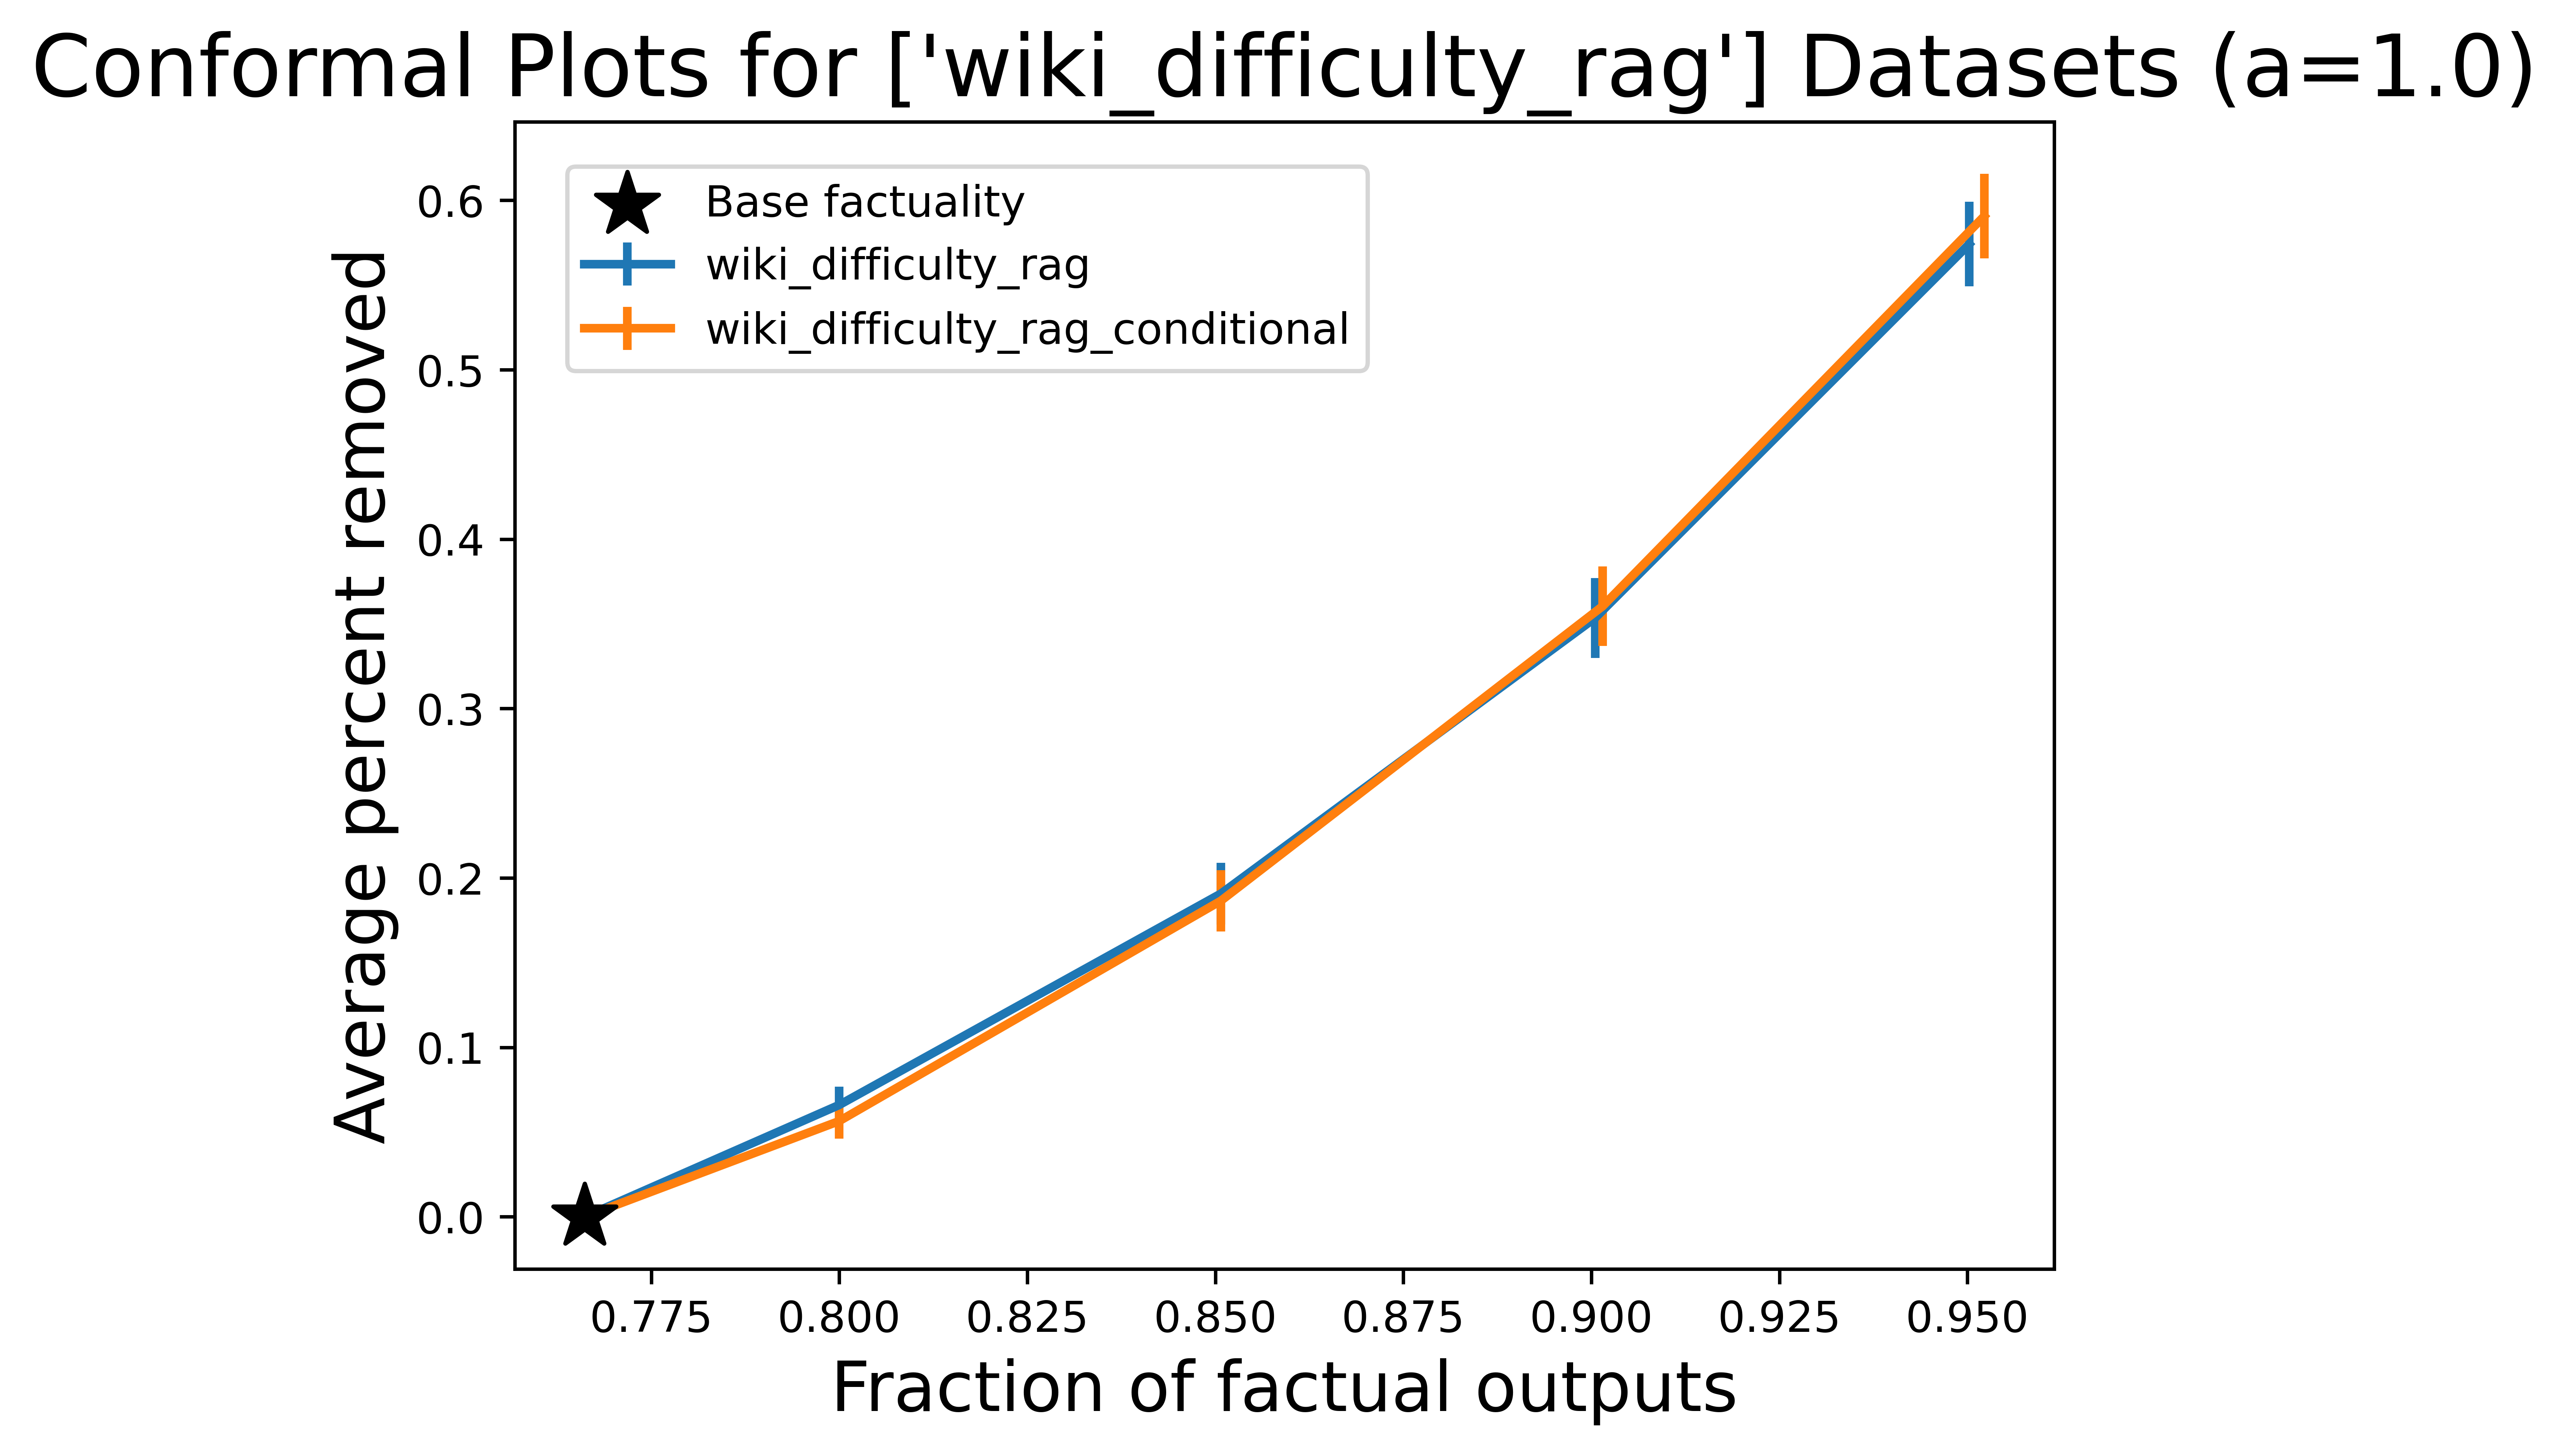

In [171]:
a=1.0
dataset_prefixs = ['wiki_difficulty_rag'] #option: medication_qa, healthsearch_qa, kqa_golden, kqa_silver_wogold, live_qa， medlfqav2
method = 'similarity'
alphas = np.arange(0.05, 0.45, 0.05)
datasets = {}
for dataset_prefix in dataset_prefixs:
    data = load_calibration(f"data/out/{dataset_prefix}_subclaims_with_scores.jsonl")
    datasets[dataset_prefix] = data

dsprefixs = "_".join(dataset_prefixs)
fig_filename = f"data/out/{dsprefixs}_{method}_a={a:.2f}_removal_conditional_fig.png"
csv_filename = f"data/out/{dsprefixs}_{method}_a={a:.2f}_removal_conditional.csv"
create_correctness_vs_removed_plot(
    dataset_prefixs, method, datasets, alphas, a, fig_filename, csv_filename, is_conformal=True ,is_conditional=True
)

Producing calibration plot: data/out/medlfqav2_similarity_a=1.00_calibration_fig.png


100%|██████████| 8/8 [1:06:54<00:00, 501.83s/it]


Results: [[[0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95

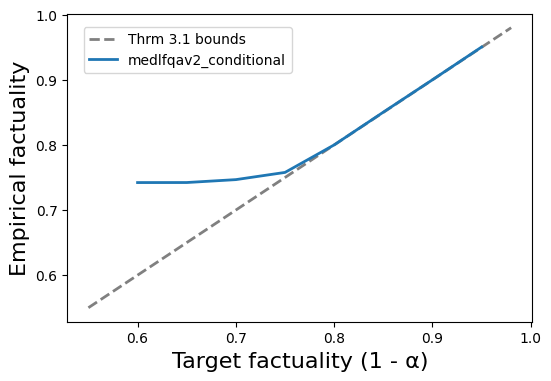

In [150]:
a=1.0
alphas = np.arange(0.05, 0.45, 0.05)
dataset_prefix = 'medlfqav2'
confidence_method = 'similarity'
data = load_calibration(f"data/out/{dataset_prefix}_subclaims_with_scores.jsonl")
fig_filename = f"data/out/{dataset_prefix}_{method}_a={a:.2f}_calibration_fig.png"
csv_filename = f"data/out/{dataset_prefix}_{method}_a={a:.2f}_calibration.csv"
create_calibration_plot(dataset_prefix, confidence_method, data, alphas, a, fig_filename, csv_filename, is_conformal = False,is_conditional=True)

Producing calibration plot: data/out/wiki_difficulty_rag_similarity_a=1.00_calibration_conditional_with_group_fig.png


100%|██████████| 8/8 [05:36<00:00, 42.09s/it]


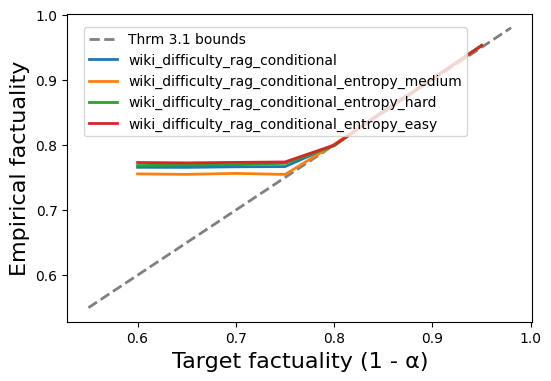

In [172]:
a=1.0
alphas = np.arange(0.05, 0.45, 0.05)
dataset_prefix = 'wiki_difficulty_rag'
confidence_method = 'similarity'
data = load_calibration(f"data/out/{dataset_prefix}_subclaims_with_scores.jsonl")
fig_filename = f"data/out/{dataset_prefix}_{method}_a={a:.2f}_calibration_conditional_with_group_fig.png"
csv_filename = f"data/out/{dataset_prefix}_{method}_a={a:.2f}_calibration_conditional_with_group.csv"
create_calibration_plot_with_subgroup(dataset_prefix, confidence_method, data, alphas, a, fig_filename, csv_filename, is_conformal = False,is_conditional=True)